## Loading Data

In [1]:
import os
import re
import ast
import typing
import requests
import icalendar
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import date, datetime
from icalendar import Calendar, Event, vCalAddress, vText

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

np.random.seed(31415)

sns.set(rc={'figure.figsize':(15,3)})
pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/nil.gordillo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
YEARS = [2023, 2022, 2021, 2020, 2019]
MONTHS = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [4]:
os.makedirs('./bicing', exist_ok=True)

if not len(os.listdir('./bicing')):
    i2m = list(zip(range(1,13), MONTHS))
    for year in YEARS:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"mv '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.csv' './bicing' ")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

In [5]:
df = pd.DataFrame()

In [6]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [7]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [80]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    new_df['percentage_docks_available'] = new_df['num_docks_available'] / (new_df['num_docks_available'] + new_df['num_bikes_available'])

    return new_df

In [9]:
def get_df_processed(df, file_name_csv: str = 'df_processed.csv'):
    if os.path.exists(file_name_csv):
        return pd.read_csv(file_name_csv)
        
    for csv in tqdm(os.listdir('./bicing')):
        new_df = pd.read_csv('./bicing/' + csv)
        new_df = process_new_df(new_df)

        # Filter out incorrect dates
        year, month, *_ = csv.split('_')
        year, month = int(year), int(month)
        new_df = new_df[(new_df.year == year) & (new_df.month == month)]

        df = pd.concat(
            [df, new_df], 
            axis=0
        )
    
    df.to_csv(file_name_csv, index=False, header=True)
    return df

df = get_df_processed(df)

In [10]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [82]:
df.shape

(15098574, 57)

In [12]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0


### Add station information

In [13]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()

In [14]:
station_json = get_station_json()

In [15]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",08013,46,True,1000.0,True,None,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",08013,29,True,1000.0,True,None,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",08013,27,True,1000.0,True,None,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",08013,21,True,1000.0,True,None,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08018,39,True,1000.0,True,None,NaN


In [16]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [17]:
station_df = station_df.drop(station_drop_fields, axis=1)
station_df.head()

,station_id,lat,lon,altitude,capacity
0,1,41.397978,2.180107,16.0,46
1,2,41.395488,2.177198,17.0,29
2,3,41.394156,2.181331,11.0,27
3,4,41.393317,2.181248,8.0,21
4,5,41.391103,2.180176,7.0,39


In [18]:
df = pd.merge(df, station_df, how='left') # TODO: Handle NaN station information

In [19]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46.0
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46.0
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46.0
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46.0
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46.0


### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [20]:
print('Start date: ', df['date'].min())
print('End date: ', df['date'].max())

Start date:  2019-07-01
End date:  2023-05-31


In [21]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [22]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [23]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [24]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [25]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [26]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [27]:
weather_df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,date
0,2019-03-28,16.8,6.4,12.1,16.8,3.7,11.5,4.4,60.6,0.0,0.0,0.0,0.0,0.0,21.5,17.3,42.8,1027.6,1.1,16.1,221.4,19.2,7.0,1553751710,1553796707,Clear,clear-day,NaN,2019-03-28
1,2019-03-29,16.3,8.8,12.8,16.3,6.7,12.6,5.1,60.6,0.0,0.0,0.0,0.0,0.0,24.8,19.8,76.9,1027.2,8.9,16.1,222.3,19.1,7.0,1553838009,1553883172,Clear,clear-day,NaN,2019-03-29
2,2019-03-30,16.0,6.4,12.0,16.0,4.2,11.6,5.8,66.0,0.0,0.0,0.0,0.0,0.0,24.3,19.1,79.9,1023.8,29.4,15.5,224.5,19.6,7.0,1553924308,1553969637,Partially cloudy,partly-cloudy-day,NaN,2019-03-30
3,2019-03-31,15.9,8.4,12.5,15.9,6.9,12.4,7.9,73.5,0.0,0.0,0.0,0.0,0.0,37.6,31.2,71.2,1017.5,50.3,14.7,154.2,12.8,6.0,1554010607,1554056102,Partially cloudy,partly-cloudy-day,NaN,2019-03-31
4,2019-04-01,17.3,9.8,13.8,17.3,9.0,13.7,6.1,60.7,0.0,0.0,0.0,0.0,0.0,23.4,18.1,126.5,1015.2,35.0,15.3,214.7,18.6,7.0,1554096907,1554142567,Partially cloudy,partly-cloudy-day,NaN,2019-04-01


In [28]:
df.date = pd.to_datetime(df.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df = pd.merge(df, weather_df, left_on='date', right_on='date', how='left')

In [29]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN


### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [30]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [31]:
covid_json = get_covid_json()

In [32]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

,Nom_Variable,Font,Data_Indicador,Territori,_full_text,Frequencia_Indicador,Valor,_id,Nom_Indicador,Unitat
0,,Agència de Salut Pública de Barcelona,2020-02-25,Barcelona,'-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...,diari,1,1,Casos de COVID-19 a Barcelona (diari),Nombre
1,,Agència de Salut Pública de Barcelona,2020-02-26,Barcelona,'-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...,diari,0,2,Casos de COVID-19 a Barcelona (diari),Nombre
2,,Agència de Salut Pública de Barcelona,2020-02-27,Barcelona,'-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...,diari,0,3,Casos de COVID-19 a Barcelona (diari),Nombre
3,,Agència de Salut Pública de Barcelona,2020-02-28,Barcelona,'-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...,diari,0,4,Casos de COVID-19 a Barcelona (diari),Nombre
4,,Agència de Salut Pública de Barcelona,2020-02-29,Barcelona,'-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...,diari,0,5,Casos de COVID-19 a Barcelona (diari),Nombre


In [33]:
covid_df.shape

(773, 10)

In [34]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

,Data_Indicador,Valor
0,2020-02-25,1
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


In [35]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [36]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [37]:
covid_df.head()

,covid_cases,date
0,1,2020-02-25
1,0,2020-02-26
2,0,2020-02-27
3,0,2020-02-28
4,0,2020-02-29


In [38]:
df = pd.merge(
    df, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [39]:
df.covid_cases = df.covid_cases.astype('float')

In [40]:
df.covid_cases.describe()

count    7.882314e+06
mean     6.792263e+02
std      1.279695e+03
min      0.000000e+00
25%      8.400000e+01
50%      2.520000e+02
75%      5.870000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<Axes: >

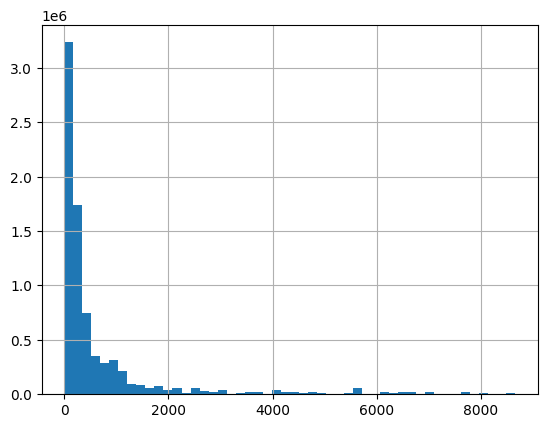

In [41]:
df.covid_cases.hist(bins=50)

In [42]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [43]:
df = fill_with_percentile(df, 'covid_cases')

Percentile 0.03 value is:  5.0


We could add also information about in which dates the people where closed into their homes.

In [44]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [45]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [46]:
index_non_confinment = df[
    (df['date'] < confinment_date_start) |
    (df['date'] > confinment_date_end)
].index

In [47]:
df.loc[index_non_confinment, 'confinment'] = 0
df['confinment'] = df['confinment'].fillna(1)
df['confinment'] = df['confinment'].astype('int')

### Barcelona Events

This dataset seems incomplete as yearly events are not repeated. So will not be used for the final model.

In [48]:
os.makedirs('./events', exist_ok=True)

In [49]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [50]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [51]:
events_df.head()

,register_id,prefix,suffix,name,created,modified,status,status_name,core_type,core_type_name,body,tickets_data,addresses,entity_types_data,attribute_categories,values,from_relationships,to_relationships,classifications_data,secondary_filters_data,timetable,image_data,gallery_data,warnings,geo_epgs_25831,geo_epgs_23031,geo_epgs_4326,is_section_of_data,sections_data,start_date,end_date,estimated_dates,languages_data,type,type_name,period,period_name,event_status_name,event_status,ical
0,99400629715,NaN,NaN,Mercat de Pagès a Vallcarca i els Penitents,2019-06-13T15:01:08+02:00,2023-05-19T10:08:59.023978+02:00,published,Publicat,event,Agenda,"<p>Parades de productes ecològics, de proximit...","[{'id': 3, 'name': 'Lliure'}]","[{'place': 'plaça del metro de Vallcarca', 'di...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 114759, 'value': 'http://www.facebook....",[],[],"[{'id': 2027, 'name': 'Petits mercats ocasiona...","[{'id': 400015, 'name': 'Petits mercats ocasio...","{'id': 27971, 'html': '<table class=""timetable...",NaN,[],"[{'id': 6991, 'text': '<p>Revisió</p>', 'type'...","{'x': 428555.9788206734, 'y': 4584832.783654237}","{'x': 428650.506964528, 'y': 4585037.344061564}","{'x': 41.411870483560705, 'y': 2.1451632515859...",NaN,NaN,2019-10-03T00:00:00+02:00,NaN,NaN,"[{'id': 1, 'language': 'Indiferent'}]",permanent,Permanent,NaN,NaN,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
1,99400622344,Campanya Vacances Estiu 2023,NaN,Casal esportiu 'Parkour i acrobàcies' per a in...,2019-03-13T09:45:46+01:00,2023-04-28T11:31:05.717773+02:00,published,Publicat,event,Agenda,<p>Campus de parkour i acrobàcies.</p><p>Insta...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': 'Institut Salvador Seguí', 'distric...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 114449, 'value': 'http://www.fip3.com/...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2074000, 'name': 'Casals esportius', '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 27304, 'html': '<table class=""timetable...",NaN,[],"[{'id': 12778, 'text': ""<p>Inscripcions a la w...","{'x': 432882.3765611512, 'y': 4586037.508796598}","{'x': 432976.8955911235, 'y': 4586242.10391194}","{'x': 41.42309401778554, 'y': 2.196790431984144}",NaN,NaN,2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
2,99400622349,Campanya Vacances Estiu 2023,NaN,Casal/Campus Esportiu 'Futbol Sala' per a infa...,2019-03-13T09:54:13+01:00,2023-04-28T11:30:57.736367+02:00,published,Publicat,event,Agenda,<p>CAMPUS DE TECNIFICACIÓ FUTBOL SALA Instal·l...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': 'Institut Salvador Seguí', 'distric...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 113819, 'value': 'http://www.fip3.com/...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2000, 'name': 'Campus', 'full_path': '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 27305, 'html': '<table class=""timetable...",NaN,[],"[{'id': 12668, 'text': ""<p>Inscripcions a la w...","{'x': 432882.3765611512, 'y': 4586037.508796598}","{'x': 432976.8955911235, 'y': 4586242.10391194}","{'x': 41.42309401778554, 'y': 2.196790431984144}",NaN,NaN,2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
3,99400076147,NaN,NaN,Exposició d'art contemporani,2004-03-09T12:49:22+01:00,2022-09-17T06:13:07.492957+02:00,published,Publicat,event,Agenda,<p>Aquest museu té un fons artístic de més de ...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': None, 'district_name': 'Sants-Montj...","[{'id': 101, 'name': 'agenda'}, {'i

In [52]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [53]:
def events_df_drop_columns(
    events_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
        'core_type', 'core_type_name',                                                                 # most is only one type of value
        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
    ]
):
    
    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [54]:
# Drop columns not wanted
events_df = events_df_drop_columns(events_df)

In [55]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [56]:
events_df.head()

,geo_epgs_4326,start_date,end_date
0,"{'x': 41.411870483560705, 'y': 2.1451632515859...",2019-10-03T00:00:00+02:00,NaN
1,"{'x': 41.42309401778554, 'y': 2.196790431984144}",2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00
2,"{'x': 41.42309401778554, 'y': 2.196790431984144}",2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00
4,"{'x': 41.42214155134015, 'y': 2.1658503000743763}",2023-07-17T03:00:00+02:00,2023-07-28T03:00:00+02:00
5,"{'x': 41.37192068979768, 'y': 2.1701826605872294}",2009-10-01T00:00:00+02:00,NaN


In [57]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [58]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(str(x)))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [59]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [60]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

In [61]:
# Filter out by maximum and minimum dates of df
df_min_date, df_max_date = df.date.min(), df.date.max()

events_df = events_df[events_df.start_date > df_min_date]
events_df = events_df[events_df.end_date < df_max_date]

In [62]:
print(events_df.shape)
events_df.head()

(87, 4)


,start_date,end_date,x,y
0,2019-10-02,2019-10-02,41.411870,2.145163
31,2020-07-14,2020-07-14,41.380700,2.185521
32,2020-07-15,2020-07-15,41.386661,2.171438
74,2023-01-01,2023-01-01,41.400303,2.202462
133,2022-11-03,2022-11-03,41.371326,2.149594


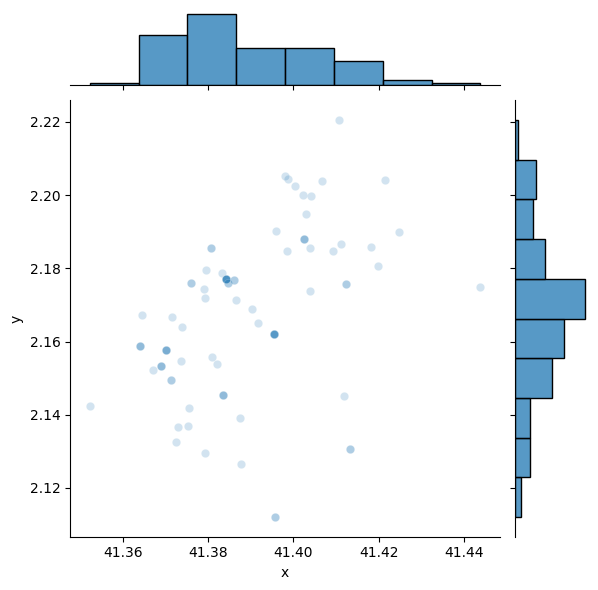

In [63]:
sns.jointplot(x="x", y="y", data=events_df, alpha=0.2)

In [64]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [65]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [
        pd.merge(df, events_df, left_on='date', right_on='start_date'), 
        pd.merge(df, events_df, left_on='date', right_on='end_date')
    ],
    axis=0
).drop_duplicates()

In [66]:
print(df_common_events.shape)
df_common_events.head()

(814524, 59)


,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,start_date,end_date,x,y
0,1,2020,6,17,0,24.500000,24.416667,0.083333,18.583333,1.0,1.0,1.0,1.592347e+09,1.0,1.0,1.592347e+09,9.083333,2020-06-17 00:00:00,2020-06-17,1.318386,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
1,1,2020,6,17,1,28.500000,28.250000,0.250000,14.750000,1.0,1.0,1.0,1.592350e+09,1.0,1.0,1.592350e+09,17.750000,2020-06-17 01:00:00,2020-06-17,1.932203,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
2,1,2020,6,17,2,28.916667,28.833333,0.083333,15.166667,1.0,1.0,1.0,1.592354e+09,1.0,1.0,1.592354e+09,20.250000,2020-06-17 02:00:00,2020-06-17,1.906593,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
3,1,2020,6,17,3,29.000000,29.000000,0.000000,15.083333,1.0,1.0,1.0,1.592357e+09,1.0,1.0,1.592358e+09,15.916667,2020-06-17 03:00:00,2020-06-17,1.922652,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
4,1,2020,6,17,4,29.000000,29.000000,0.000000,17.000000,1.0,1.0,1.0,1.592361e+09,1.0,1.0,1.592361e+09,14.250000,2020-06-17 04:00:00,2020-06-17,1.705882,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894


In [67]:
df_common_events.date

0         2020-06-17
1         2020-06-17
2         2020-06-17
3         2020-06-17
4         2020-06-17
             ...    
925424    2020-09-30
925425    2020-09-30
925426    2020-09-30
925427    2020-09-30
925428    2020-09-30
Name: date, Length: 814524, dtype: object

In [68]:
df_common_events.year.unique()

array([2020, 2019, 2021, 2023, 2022])

In [69]:
with tqdm(total=len(events_df)) as pbar:
    for idx, row in events_df.iterrows():    
        # Filter by the range of the dates
        x, y = row.x, row.y
        start_date, end_date = row['start_date'], row['end_date']
        range_dates = pd.date_range(start_date, end_date)
        range_df = df_common_events[df_common_events.date.isin([range_date.date() for range_date in range_dates])]
        
        if len(range_df) > 0:
            # Near position of the event with relation of the biking center (30% of standard deviations of x & y)
            range_df = range_df[(range_df.lat > x - std_dev_x * 0.3) & (range_df.lat < x + std_dev_x * 0.3)]
            range_df = range_df[(range_df.lat > y - std_dev_y * 0.3) & (range_df.lat < y + std_dev_y * 0.3)]
            df.loc[range_df.index, 'has_event'] = 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:01<00:00, 71.09it/s]


In [70]:
df.has_event = df.has_event.fillna(0)

### Public Holidays

In [71]:
e = open('calendarifestius_en.ics', 'rb')
ecal = icalendar.Calendar.from_ical(e.read())
for component in ecal.walk():
    print(component.name)
e.close()

VCALENDAR
VTIMEZONE
DAYLIGHT
STANDARD
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT


In [72]:
def get_cal_events(ecal):
    # Extract relevant information
    events = []
    for event in ecal.walk('VEVENT'):
        event_data = {
            'Summary': event.get('summary'),
            'Start': event.get('dtstart').dt,
            'End': event.get('dtend').dt,
            # Add more properties as needed
        }
        events.append(event_data)

    # Create a DataFrame from the extracted information
    return pd.DataFrame(events)

In [73]:
df_ecal = get_cal_events(ecal)

# Print the DataFrame
print(df_ecal.dtypes)

Summary    object
Start      object
End        object
dtype: object


In [74]:
df_ecal['Start'] = pd.to_datetime(df_ecal['Start'], utc=True).dt.date
df_ecal['End'] = pd.to_datetime(df_ecal['End'], utc=True).dt.date
df_ecal.head()

,Summary,Start,End
0,Epiphany / Three Kings’ Day,2023-01-06,2023-01-07
1,Good Friday,2023-04-07,2023-04-08
2,Easter Monday,2023-04-10,2023-04-11
3,Labour Day,2023-05-01,2023-05-02
4,Local holidays in Barcelona,2023-06-05,2023-06-06


In [75]:
df_ecal = df_ecal.rename(columns={
    "Start": 'start_date', 
    "End": 'end_date', 
    "Summary":"name"
})
df_ecal.head()

,name,start_date,end_date
0,Epiphany / Three Kings’ Day,2023-01-06,2023-01-07
1,Good Friday,2023-04-07,2023-04-08
2,Easter Monday,2023-04-10,2023-04-11
3,Labour Day,2023-05-01,2023-05-02
4,Local holidays in Barcelona,2023-06-05,2023-06-06


In [76]:
with tqdm(total=len(df_ecal)) as pbar:
    for idx, row in df_ecal.iterrows():    
        start_date, end_date = row['start_date'], row['end_date']
        
        for year in YEARS:
            holiday_start_date = date(year, start_date.month, start_date.day)
            holiday_end_date = date(year, end_date.month, end_date.day)
            range_dates = pd.date_range(holiday_start_date, holiday_end_date)
            range_df = df[df.date.isin([range_date.date() for range_date in range_dates])]
            
            if len(range_df) > 0:
                df.loc[range_df.index, 'has_holiday'] = 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


In [77]:
# Check some dates
df[df.has_holiday.notnull()].head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,has_event,has_holiday
95,1,2020,6,5,0,16.583333,16.583333,0.000000,28.416667,1.0,1.0,1.0,1.591310e+09,1.0,1.0,1.591310e+09,18.166667,2020-06-05 00:00:00,2020-06-05,0.583578,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
96,1,2020,6,5,1,16.000000,16.000000,0.000000,29.000000,1.0,1.0,1.0,1.591313e+09,1.0,1.0,1.591314e+09,14.000000,2020-06-05 01:00:00,2020-06-05,0.551724,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
97,1,2020,6,5,2,16.250000,16.250000,0.000000,28.750000,1.0,1.0,1.0,1.591317e+09,1.0,1.0,1.591317e+09,17.833333,2020-06-05 02:00:00,2020-06-05,0.565217,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
98,1,2020,6,5,3,17.166667,17.000000,0.166667,28.000000,1.0,1.0,1.0,1.591321e+09,1.0,1.0,1.591321e+09,16.666667,2020-06-05 03:00:00,2020-06-05,0.613095,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
99,1,2020,6,5,4,17.583333,17.000000,0.583333,28.416667,1.0,1.0,1.0,1.591324e+09,1.0,1.0,1.591324e+09,13.000000,2020-06-05 04:00:00,2020-06-05,0.618768,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0


In [78]:
df['has_holiday'] = df['has_holiday'].fillna(0)
df['has_holiday'] = df['has_holiday'].astype('int')

In [79]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,has_event,has_holiday
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0


### Traffic

In [83]:
os.makedirs('./traffic', exist_ok=True)

In [84]:
TRAFFIC_BASE_URL = "https://opendata-ajuntament.barcelona.cat/data/en/dataset/trams"

In [ ]:
if not os.listdir('./traffic'):
    response = requests.get(TRAFFIC_BASE_URL)
    
    soup = BeautifulSoup(response.content)
    resource_items = soup.find_all("li", {"class": "resource-item"})
    
    for resource_item in resource_items[1:]:
        file_name: str = resource_item.find('a').text[:-4]
        anchor_download_path = resource_item.find('a', href=re.compile(r'^https://opendata-ajuntament.barcelona.cat/data/dataset/*'))
        url_download_path = anchor_download_path['href']

        os.system(f"wget '{url_download_path}'")
        os.system(f"mv 'download' './traffic/{file_name.replace('\n', '').strip()}' ")

In [87]:
traffic_df = pd.DataFrame()

In [88]:
for csv in tqdm(os.listdir('./traffic')):
    year, month, *_ = csv.split('_')
    year, month = int(year), int(month)
    
    if year not in YEARS:
        continue
        
    new_traffic_df = pd.read_csv('./traffic/' + csv, on_bad_lines='skip')
    new_traffic_df['date'] = pd.to_datetime(
        new_traffic_df['data'], format='%Y%m%d%H%M%S'
    )
    new_traffic_df = new_traffic_df.drop(['data'], axis=1)
    
    new_traffic_df['year'] = new_traffic_df['date'].dt.year
    new_traffic_df['month'] = new_traffic_df['date'].dt.month
    new_traffic_df['day'] = new_traffic_df['date'].dt.day
    new_traffic_df['hour'] = new_traffic_df['date'].dt.hour
    
    new_traffic_df = new_traffic_df.groupby(
        [
            # 'idTram', --> have not the mapping to the zone
            'year', 
            'month', 
            'day', 
            'hour'
        ])\
        .mean(numeric_only=True)\
        .reset_index()\
        .drop(['idTram'], axis=1)
    
    traffic_df = pd.concat(
        [traffic_df, new_traffic_df], 
        axis=0
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:55<00:00,  1.27it/s]


In [89]:
df = pd.merge(
    df,
    traffic_df,
    how='left',
    left_on=('year', 'month', 'day', 'hour'),
    right_on=('year', 'month', 'day', 'hour')
)

In [ ]:
df.to_csv(
    'df.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

### Selected Columns

In [90]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,has_event,has_holiday,estatActual,estatPrevist
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.824380,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.140101
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.816434,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.104522
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.823864,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.096932
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.099304
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.098830


In [91]:
df.columns.values

array(['station_id', 'year', 'month', 'day', 'hour',
       'num_bikes_available', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'last_reported',
       'is_charging_station', 'status', 'last_updated', 'ttl',
       'date_time', 'date', 'percentage_docks_available', 'traffic',
       'lat', 'lon', 'altitude', 'capacity', 'datetime', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike',
       'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy',
       'uvindex', 'sunriseEpoch', 'sunsetEpoch', 'conditions', 'icon',
       'severerisk', 'covid_cases', 'confinment', 'has_event',
       'has_holiday', 'estatActual', 'estatPrevist'], dtype=object)

Once we have extended our dataframe with external sources, we are going to make the selection of the columns that we want.

In [92]:
selected_columns_df = [
    'station_id', 
    # 'num_bikes_available', 'num_bikes_available_types.mechanical',                          # unnecessary docks info
    # 'num_bikes_available_types.ebike', 'num_docks_available', 
    'percentage_docks_available',                                                             # docks info
    # 'status', 
    'lat', 'lon', 'altitude', 'capacity',                                                     # station info
    'year', 'month', 'day', 'hour', 'date_time', 'date',                                      # time info
    'covid_cases', 'confinment', 'has_holiday', # 'has_event' -> incomplete                   # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility',  # meteorological info
    'estatActual', 'traffic'
]

selected_df = df[selected_columns_df]

In [93]:
# Checkpoint of the extended df with external sources
selected_df.to_csv(
    'df_selected.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

## Data Engineering

Engineer new variables from the information that we already have. 

In [94]:
selected_df.date_time = pd.to_datetime(selected_df.date_time)

### Time

In [95]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [96]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [97]:
selected_df['day_info'] = selected_df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [98]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [99]:
selected_df['hour_info'] = selected_df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [100]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [101]:
selected_df['month_info'] = selected_df.date_time.apply(lambda x: get_month_info(x))

In [102]:
selected_df.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info
0,1,7.727273,7.727273,0.0,36.272727,0.824380,1.0,41.397978,2.180107,16.0,46.0,2020,6,1,0,2020-06-01 00:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
1,1,8.076923,8.076923,0.0,35.923077,0.816434,1.0,41.397978,2.180107,16.0,46.0,2020,6,1,1,2020-06-01 01:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
2,1,7.750000,7.750000,0.0,36.250000,0.823864,1.0,41.397978,2.180107,16.0,46.0,2020,6,1,2,2020-06-01 02:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
3,1,8.000000,8.000000,0.0,36.000000,0.818182,1.0,41.397978,2.180107,16.0,46.0,2020,6,1,3,2020-06-01 03:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
4,1,8.000000,8.000000,0.0,36.000000,0.818182,1.0,41.397978,2.180107,16.0,46.0,2020,6,1,4,2020-06-01 04:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer


### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [103]:
selected_df = selected_df.sort_values(['station_id', 'date_time'], ascending=True)

In [104]:
df_shifted = pd.DataFrame()

In [105]:
for station_id in tqdm(selected_df.station_id.unique()):
    station_df = selected_df[selected_df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 516/516 [11:02<00:00,  1.28s/it]


In [106]:
df_shifted.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1
2738582,532,0.666667,0.0,0.666667,0.333333,0.333333,1.0,NaN,NaN,NaN,NaN,2022,11,11,10,2022-11-11 10:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.280702,0.0,weekday,morning,autumn,NaN,NaN,NaN,NaN
2738583,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,11,2022-11-11 11:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.643014,0.0,weekday,morning,autumn,NaN,NaN,NaN,0.333333
2738584,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,12,2022-11-11 12:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.690946,0.0,weekday,morning,autumn,NaN,NaN,0.333333,0.000000
2738585,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,13,2022-11-11 13:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.712876,0.0,weekday,noon,autumn,NaN,0.333333,0.000000,0.000000
2738586,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,14,2022-11-11 14:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.737312,0.0,weekday,noon,autumn,0.333333,0.000000,0.000000,0.000000


In [107]:
df_shifted.to_csv('./df_shifted_checkpoint.csv', index=False, header=True)

In [2]:
df_shifted = pd.read_csv('./df_shifted_checkpoint.csv')

### Train / Val / Test Split

In [108]:
df_shifted.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1
2738582,532,0.666667,0.0,0.666667,0.333333,0.333333,1.0,NaN,NaN,NaN,NaN,2022,11,11,10,2022-11-11 10:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.280702,0.0,weekday,morning,autumn,NaN,NaN,NaN,NaN
2738583,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,11,2022-11-11 11:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.643014,0.0,weekday,morning,autumn,NaN,NaN,NaN,0.333333
2738584,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,12,2022-11-11 12:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.690946,0.0,weekday,morning,autumn,NaN,NaN,0.333333,0.000000
2738585,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,13,2022-11-11 13:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.712876,0.0,weekday,noon,autumn,NaN,0.333333,0.000000,0.000000
2738586,532,1.000000,0.0,1.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,2022,11,11,14,2022-11-11 14:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.737312,0.0,weekday,noon,autumn,0.333333,0.000000,0.000000,0.000000


In [4]:
train_df = df_shifted[df_shifted.year != 2023]
test_df = df_shifted[df_shifted.year == 2023]

In [5]:
print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])

Train size:  13404710
Test size:  1693864


In [6]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

## Data Exploration

In [7]:
# Exploring a sample of the train data might be enough to already get some insights
train_df_sampled = train_df.sample(frac=.01)

### Time Variables

In [8]:
train_df_sampled\
    .groupby('hour_info')['percentage_docks_available']\
    .mean()\
    .sort_values(ascending=False)

hour_info
eve              0.648868
noon             0.638778
morning          0.626219
night            0.616973
early_morning    0.598954
late_night       0.591913
Name: percentage_docks_available, dtype: float64

### Traffic Variables

Variation of the traffic during the day.

<Axes: xlabel='hour'>

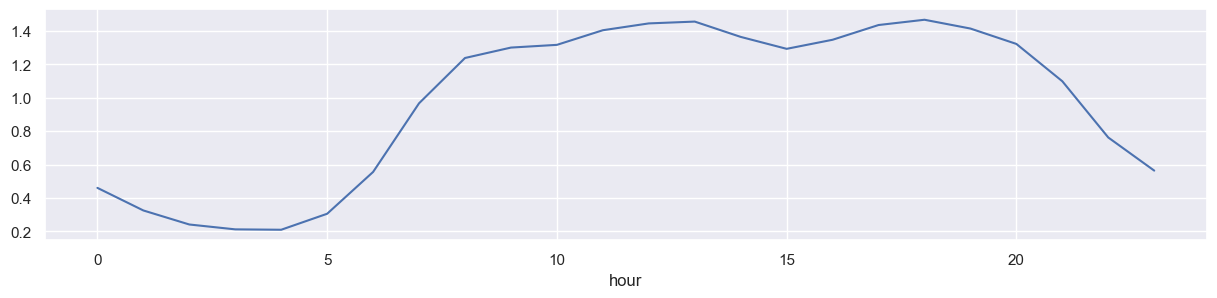

In [9]:
train_df_sampled.groupby('hour')['estatActual'].mean().plot()

In [10]:
# We can see a linear correlation of around 10% between the amount of traffic and % docks available
train_df_sampled[['percentage_docks_available', 'estatActual']].corr()

,percentage_docks_available,estatActual
percentage_docks_available,1.00000,0.09377
estatActual,0.09377,1.00000


## Handling Nulls

In [11]:
train_df.isnull().sum(axis=0)

station_id                                   0
num_bikes_available                          0
num_bikes_available_types.mechanical         0
num_bikes_available_types.ebike              0
num_docks_available                          0
percentage_docks_available                5177
status                                       0
lat                                      15855
lon                                      15855
altitude                                 15855
capacity                                 15855
year                                         0
month                                        0
day                                          0
hour                                         0
date_time                                    0
date                                         0
covid_cases                                  0
confinment                                   0
has_holiday                                  0
temp                                         0
feelslike    

For the percentage of docks available, we will assume it is 0

In [12]:
# percentage_docks_available is null if we divided 0 / 0
train_df[train_df['percentage_docks_available'].isnull()].head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1
20263,519,0.0,0.0,0.0,0.0,NaN,1.0,41.424655,2.166289,110.0,24.0,2022,12,9,13,2022-12-09 13:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.614818,0.0,weekday,noon,winter,0.809028,0.840278,0.868056,0.848485
20264,519,0.0,0.0,0.0,0.0,NaN,1.0,41.424655,2.166289,110.0,24.0,2022,12,9,14,2022-12-09 14:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.520207,0.0,weekday,noon,winter,0.840278,0.868056,0.848485,NaN
20265,519,0.0,0.0,0.0,0.0,NaN,1.0,41.424655,2.166289,110.0,24.0,2022,12,9,15,2022-12-09 15:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.453634,0.0,weekday,noon,winter,0.868056,0.848485,NaN,NaN
20266,519,0.0,0.0,0.0,0.0,NaN,1.0,41.424655,2.166289,110.0,24.0,2022,12,9,16,2022-12-09 16:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.496084,0.0,weekday,noon,winter,0.848485,NaN,NaN,NaN
20267,519,0.0,0.0,0.0,0.0,NaN,1.0,41.424655,2.166289,110.0,24.0,2022,12,9,17,2022-12-09 17:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.567513,0.0,weekday,eve,winter,NaN,NaN,NaN,NaN


In [13]:
train_df['percentage_docks_available'] = train_df['percentage_docks_available'].fillna(.0)
valid_df['percentage_docks_available'] = valid_df['percentage_docks_available'].fillna(.0)
test_df['percentage_docks_available'] = test_df['percentage_docks_available'].fillna(.0)

/var/folders/_m/3xk3lkv56h1ft3h425mswtn80000gn/T/ipykernel_52592/1403196022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['percentage_docks_available'] = train_df['percentage_docks_available'].fillna(.0)


For the context that are nulls, we will assume it is their actual one.

In [14]:
# Context: fill with the before one
train_df['ctx-4'] = train_df['ctx-4'].fillna(train_df['percentage_docks_available'])
train_df['ctx-3'] = train_df['ctx-3'].fillna(train_df['percentage_docks_available'])
train_df['ctx-2'] = train_df['ctx-2'].fillna(train_df['percentage_docks_available'])
train_df['ctx-1'] = train_df['ctx-1'].fillna(train_df['percentage_docks_available'])

valid_df['ctx-4'] = valid_df['ctx-4'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-3'] = valid_df['ctx-3'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-2'] = valid_df['ctx-2'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-1'] = valid_df['ctx-1'].fillna(valid_df['percentage_docks_available'])

test_df['ctx-4'] = test_df['ctx-4'].fillna(test_df['percentage_docks_available'])
test_df['ctx-3'] = test_df['ctx-3'].fillna(test_df['percentage_docks_available'])
test_df['ctx-2'] = test_df['ctx-2'].fillna(test_df['percentage_docks_available'])
test_df['ctx-1'] = test_df['ctx-1'].fillna(test_df['percentage_docks_available'])

/var/folders/_m/3xk3lkv56h1ft3h425mswtn80000gn/T/ipykernel_52592/1286628089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ctx-4'] = train_df['ctx-4'].fillna(train_df['percentage_docks_available'])
/var/folders/_m/3xk3lkv56h1ft3h425mswtn80000gn/T/ipykernel_52592/1286628089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ctx-3'] = train_df['ctx-3'].fillna(train_df['percentage_docks_available'])
/var/folders/_m/3xk3lkv56h1ft3h425mswtn80000gn/T/ipykernel_52592/1286628089.py:4: Sett

For the station information, we will put the **mean**.

In [15]:
# Lat, Long, Altittude & Capacity: some stations have missing information
train_df[train_df['lat'].isnull()].station_id.unique()

array([532, 530, 529, 520,  93,  59])

In [16]:
STATION_INFO = ['lat', 'lon', 'altitude', 'capacity']

In [17]:
station_info_imputer = SimpleImputer(strategy='mean')
station_info_imputer.fit(train_df[STATION_INFO])

SimpleImputer()

In [51]:
def input_missing_with_imputer(df: pd.DataFrame, imputer: SimpleImputer = station_info_imputer, columns: typing.List[str] = STATION_INFO):
    df_null = df[df[columns[0]].isnull()]
    
    if df_null.empty:
        return df
    
    df_null_values = imputer.transform(df_null[columns])
    df.loc[df_null.index, columns] = df_null_values
    
    return df

In [48]:
train_df = input_missing_with_imputer(train_df)
valid_df = input_missing_with_imputer(valid_df)
test_df = input_missing_with_imputer(test_df)

For the traffic actual state, we will also use a simple imputer.

In [45]:
traffic_info_imputer = SimpleImputer(strategy='mean')
traffic_info_imputer.fit(train_df['estatActual'].values.reshape(-1, 1))

SimpleImputer()

In [52]:
train_df = input_missing_with_imputer(train_df, traffic_info_imputer, ['estatActual'])
valid_df = input_missing_with_imputer(valid_df, traffic_info_imputer, ['estatActual'])
test_df = input_missing_with_imputer(test_df, traffic_info_imputer, ['estatActual'])

/Users/nil.gordillo/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/Users/nil.gordillo/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/Users/nil.gordillo/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [57]:
train_df.isnull().sum()

station_id                    0
percentage_docks_available    0
status                        0
lat                           0
lon                           0
altitude                      0
capacity                      0
year                          0
month                         0
day                           0
hour                          0
date_time                     0
date                          0
covid_cases                   0
confinment                    0
has_holiday                   0
temp                          0
feelslike                     0
humidity                      0
precip                        0
snow                          0
windspeed                     0
uvindex                       0
visibility                    0
estatActual                   0
traffic                       0
day_info                      0
hour_info                     0
month_info                    0
ctx-4                         0
ctx-3                         0
ctx-2   

## Handling Categoric

### Clustering

We could group the bicying stations by clusters, as some of them might have greater or lower usage.

Then, based on the **station_id**, we could know to which cluster it is refering.

Afterwards, with those same groups we could see if some of them given the predicted percentage could be given more capacity or stations.

In [116]:
COORDINATES_INFO = ['lat', 'lon']

X_cluster_coordinates = train_df[['station_id', 'altitude', *COORDINATES_INFO]]\
    .drop_duplicates()\
    .reset_index(drop=True)

In [117]:
X_cluster_coordinates.station_id.nunique()

516

In [118]:
kmeans_coordinates = KMeans(n_clusters=15, init='k-means++')

In [119]:
coordinates_scaler = MinMaxScaler()
X_cluster_coordinates[COORDINATES_INFO] = coordinates_scaler.fit_transform(X_cluster_coordinates[COORDINATES_INFO])

In [120]:
X_cluster_coordinates['cluster_label'] = kmeans_coordinates.fit_predict(X_cluster_coordinates)

/Users/nil.gordillo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='lat', ylabel='lon'>

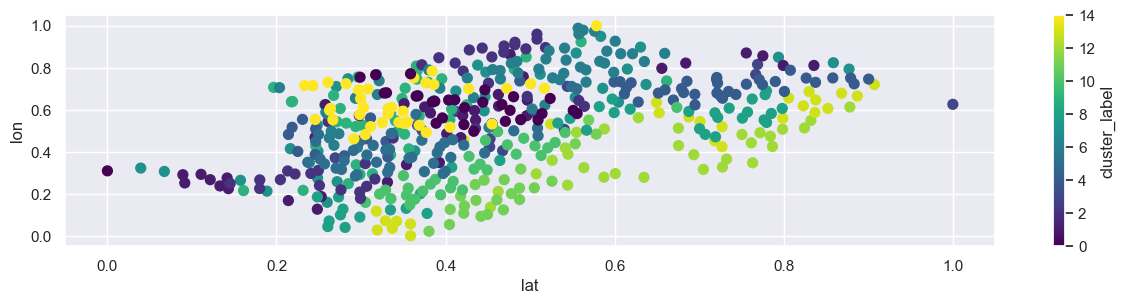

In [121]:
X_cluster_coordinates.plot.scatter(x='lat', y='lon', c='cluster_label', s=50, cmap='viridis')

In [122]:
cluster_df = X_cluster_coordinates.drop(COORDINATES_INFO, axis=1)
cluster_df # for adding this info, will do a merge

,station_id,altitude,cluster_label
0,532,34.141471,3
1,530,34.141471,3
2,529,34.141471,3
3,520,34.141471,3
4,519,110.000000,12
...,...,...,...
511,5,7.000000,0
512,4,8.000000,0
513,3,11.000000,0
514,2,17.000000,0


In [123]:
# We no longer need lat and lon
train_df = train_df.drop(COORDINATES_INFO, axis=1)
valid_df = valid_df.drop(COORDINATES_INFO, axis=1)
test_df = test_df.drop(COORDINATES_INFO, axis=1)

### Dummyfication

In [128]:
train_df

,station_id,percentage_docks_available,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1
0,532,0.333333,34.141471,26.95505,2022,11,11,10,2022-11-11 10:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.280702,0.0,weekday,morning,autumn,0.333333,0.333333,0.333333,0.333333
1,532,0.000000,34.141471,26.95505,2022,11,11,11,2022-11-11 11:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.643014,0.0,weekday,morning,autumn,0.000000,0.000000,0.000000,0.333333
2,532,0.000000,34.141471,26.95505,2022,11,11,12,2022-11-11 12:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.690946,0.0,weekday,morning,autumn,0.000000,0.000000,0.333333,0.000000
3,532,0.000000,34.141471,26.95505,2022,11,11,13,2022-11-11 13:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.712876,0.0,weekday,noon,autumn,0.000000,0.333333,0.000000,0.000000
4,532,0.000000,34.141471,26.95505,2022,11,11,14,2022-11-11 14:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.737312,0.0,weekday,noon,autumn,0.333333,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15095210,1,0.257246,16.000000,46.00000,2022,12,31,19,2022-12-31 19:00:00,2022-12-31,5.0,0,0,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,1.384242,0.0,weekend,eve,winter,0.509091,0.466302,0.455373,0.340580
15095211,1,0.119565,16.000000,46.00000,2022,12,31,20,2022-12-31 20:00:00,2022-12-31,5.0,0,0,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,1.361685,0.0,weekend,eve,winter,0.466302,0.455373,0.340580,0.257246
15095212,1,0.108696,16.000000,46.00000,2022,12,31,21,2022-12-31 21:00:00,2022-12-31,5.0,0,0,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,1.096491,0.0,weekend,night,winter,0.455373,0.340580,0.257246,0.119565
15095213,1,0.117754,16.000000,46.00000,2022,12,31,22,2022-12-31 22:00:00,2022-12-31,5.0,0,0,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,0.682331,0.0,weekend,night,winter,0.340580,0.257246,0.119565,0.108696


## Handling Numeric Data

## Features

Based on the station_id, we are going to get:
- capacity
- status
- altitude

And some will not be used:
- _lat/lon_: will not be used

--------------------------------

On the time, we will already be given:
- month
- day
- hour
- has_holiday: will know if is a holiday
- day_info / hour_info / month_info: with the functions created
- feelslike / humidity / precip / snow / windspeed / uvindex / visibility / 
- confinment: most likely 0
- covid_case: input the percentile

--------------------------------

And for other time variables, we will not use them:
- _year_
- _date_
- _date_time_